In [46]:
# ignore warnings
#import warnings
#warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset

from sklearn.preprocessing import StandardScaler

import gym
from gym import spaces

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import torch.nn as nn
import torch.optim as optim

import random
from collections import deque
import matplotlib.pyplot as plt

# The following allows to save plots in SVG format.
import matplotlib_inline
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

## Read training data

In [49]:
def read_data_csv(path):
    df = pd.read_csv(path, index_col='Date', parse_dates=True, \
        dtype={'Open': float, 'High': float, 'Low': float, 'Close': float,'Volume': float, \
            'Median': float, 'Typical': float, 'EMA(5)': float, 'EMA(12)': float, 'OBV': float, \
            'MACD(26,12,9)': float, 'MACD(26,12,9) signal': float, 'MACD(26,12,9) diff': float})
    df.drop('Median', axis=1, inplace=True)
    df.drop('Typical', axis=1, inplace=True)
    return df

df_train = read_data_csv('data.training.csv')
df_test = read_data_csv('data.testing.csv')

## Sequence length

In [50]:
date_first = df_train.index.min()
date_last = df_train.index.max()
date_last_minus_year = date_last - DateOffset(years=1)
print('first:', date_first)
print('last:', date_last)
print('last - 1 year:', date_last_minus_year)

# Since we are going to use 1 year as the maximum episodes,
# we need to make sure that the last year of the training data
# will be used for the sliding window

df = df_train[:date_last_minus_year]
equence_length = len(df)
print('sequence length:', equence_length)
#df.tail()

first: 1962-01-02 00:00:00-05:00
last: 2011-11-21 00:00:00-05:00
last - 1 year: 2010-11-21 00:00:00-05:00
sequence length: 12308


## Scale the data

In [51]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

scaler = StandardScaler()
features_to_scale = [col for col in df_train.columns if col not in ['Close']]
df_train_scaled = scaler.fit_transform(df_train[features_to_scale])
df_train_scaled = pd.DataFrame(df_train_scaled, columns=features_to_scale, index=df_train.index)
df_train_scaled['Close'] = df_train['Close']
#df_train_scaled.tail()

df_test_scaled = scaler.fit_transform(df_test[features_to_scale])
df_test_scaled = pd.DataFrame(df_test_scaled, columns=features_to_scale, index=df_test.index)
df_test_scaled['Close'] = df_test['Close']
#df_test_scaled.tail()


## DQN (Deep Q Network)

Definitions

- Agent: the algorithm that can be trained to choose the optimal actions at each state to maximize the total rewards
- Environment: a stock trading simulation with which the agent can interact
- A (Action): hold, buy, and sell
- R (Reward): positive R when profit > 0, negative R when profit < 0
- S (State): stock info (given by a sliding window), balance, position, profits
- $Q(s,a)$: the expected return of taking action $a$ at state $s$
- Episode: $S_0, A_0, R_1, S_1, A_1, R_2, \ldots, S_t, A_t, R_{t+1}, \ldots, S_{T-1}, A_{T-1}, R_T, S_T$
- Transition Quintuple: 5 essential elements to calculate Q, expressed as $(s', a, r, s, done)$

## Environment

An environment is built using the OpenAI gym to simulate stock trading. The environment consists of 3 crucial methods: 1. reset() 2. get_observation() 3. step() 4. render()

- the reset method restores the environment to the initial state at the beginning of a new episode
- the get_observation method concatenates the state information
- the step method assigns rewards and returns 3 components of the transition quintuple: next_state, reward, and done (if an episode is done or not). The render method renders real-time information to the screen

In [52]:
import gym
from gym import spaces
import numpy as np
import pandas as pd

class StockTradingEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, df, initial_balance=50000, loss_limit=-4000, window=70):
        super().__init__()
        self.df = df
        self.initial_balance = initial_balance
        self.loss_limit = loss_limit
        self.window = window  # historical price window
        self.action_space = spaces.Discrete(3)  # 0: Hold, 1: Buy 1 stock, 2: Sell all

    # Reset the environment to the initial state
    def reset(self):
        self.current_step = self.window
        self.done = False
        self.total_profit = 0
        self.balance = self.initial_balance # available balance
        self.positions = []  # store positions
        self.history = self.df.iloc[self.current_step-self.window:self.current_step].values # initial history
        return self.get_observation()  # get_observation for the initial state

    def get_observation(self):
        stock_info = self.history
        extra_info = np.repeat([[self.total_profit, self.balance, sum(self.positions)]], self.window, axis=0)
        return np.concatenate([stock_info, extra_info], axis=1) # Concatenate along the features axis

    # Get quintuple components
    def step(self, action):

        self.current_price = self.df.iloc[self.current_step-1]['Close']
        reward = 0  # Initialize reward

        if action == 1:  # buy
            self.balance -= self.current_price # adjust balance
            self.positions.append(self.current_price) # buy one stock at current price

        elif action == 2:  # sell
            if self.positions:
                sold_amount = sum(self.positions)
                gains = self.current_price*len(self.positions) - sold_amount
                self.balance += self.current_price*len(self.positions) # adjust balance
                self.total_profit += gains
                reward = gains
                self.positions = [] # clear positions
            else:
                reward = -10  # negative reward for invalid sell with no stocks

        self.current_step += 1
        # Check if the episode is done
        if self.total_profit <= self.loss_limit or self.current_step >= self.df.shape[0]:
            self.done = True

        self.history = np.array(self.df.iloc[self.current_step-self.window:self.current_step]) # update history
        next_state = self.get_observation() # Get observation of the next step

        return next_state, reward, self.done, {'Trade price': self.current_price , 'Total profit': self.total_profit, 'Available balance': self.balance, 'Position value': sum(self.positions)}

    # Render the environment
    def render(self, mode='human', close=False):
        action = self.action_space.sample() # choose a random action
        next_state, reward, done, info = self.step(action)
        print(f'Step:{self.current_step}')
        print(f'Next State: {next_state}')
        print(f"Action:{action}, Reward:{reward}, Done:{done}, Info:{info}")

Test the functionality of the environment using a subset of the data

In [53]:
# keep only first 15 rows of df_train
data = df_train_scaled.iloc[:15][['Close', 'RSI(14)', 'EMA(5)', 'OBV']]
data

,Close,RSI(14),EMA(5),OBV
Date,,,,
1962-01-02 00:00:00-05:00,1.526557,3.226779,-0.784973,-1.202902
1962-01-03 00:00:00-05:00,1.539900,3.226779,-0.784953,-1.201710
1962-01-04 00:00:00-05:00,1.524555,-1.354574,-0.784975,-1.202780
1962-01-05 00:00:00-05:00,1.494531,-3.035388,-0.785163,-1.204276
1962-01-08 00:00:00-05:00,1.466509,-3.294956,-0.785526,-1.206507
1962-01-09 00:00:00-05:00,1.483856,-1.969099,-0.785735,-1.204490
1962-01-10 00:00:00-05:00,1.486524,-1.807070,-0.785898,-1.203268
1962-01-11 00:00:00-05:00,1.502538,-1.158815,-0.785973,-1.201955
1962-01-12 00:00:00-05:00,1.505206,-0.603522,-0.785971,-1.200152


The window size is set to be 3, so the initial state returns the price information of the first 3 days, total profit (0), available balance (50000), and position value (0):

In [54]:
# Create the environment
env = StockTradingEnv(data, window=3)

# Check initial state
initial_state = env.reset()
initial_state

array([[ 1.52655697e+00,  3.22677918e+00, -7.84973301e-01,
        -1.20290175e+00,  0.00000000e+00,  5.00000000e+04,
         0.00000000e+00],
       [ 1.53990042e+00,  3.22677918e+00, -7.84953292e-01,
        -1.20171032e+00,  0.00000000e+00,  5.00000000e+04,
         0.00000000e+00],
       [ 1.52455485e+00, -1.35457428e+00, -7.84974958e-01,
        -1.20277956e+00,  0.00000000e+00,  5.00000000e+04,
         0.00000000e+00]])

The first step begins at step4, and the trade price at the current time step is the latest ‘Close’ in the current state (the current state of step4 is the initial state); The episode ends at step15 because the data has 15 samples

In [55]:
# Test the environment
observation = env.reset()
for i in range(12):
    env.render()
    print()

# Close the environment
env.close()

Step:4
Next State: [[ 1.53990042e+00  3.22677918e+00 -7.84953292e-01 -1.20171032e+00
   0.00000000e+00  4.99984754e+04  1.52455485e+00]
 [ 1.52455485e+00 -1.35457428e+00 -7.84974958e-01 -1.20277956e+00
   0.00000000e+00  4.99984754e+04  1.52455485e+00]
 [ 1.49453127e+00 -3.03538783e+00 -7.85163400e-01 -1.20427649e+00
   0.00000000e+00  4.99984754e+04  1.52455485e+00]]
Action:1, Reward:0, Done:False, Info:{'Trade price': 1.5245548486709597, 'Total profit': 0, 'Available balance': 49998.47544515133, 'Position value': 1.5245548486709597}

Step:5
Next State: [[ 1.52455485e+00 -1.35457428e+00 -7.84974958e-01 -1.20277956e+00
  -3.00235748e-02  4.99999700e+04  0.00000000e+00]
 [ 1.49453127e+00 -3.03538783e+00 -7.85163400e-01 -1.20427649e+00
  -3.00235748e-02  4.99999700e+04  0.00000000e+00]
 [ 1.46650863e+00 -3.29495611e+00 -7.85525842e-01 -1.20650662e+00
  -3.00235748e-02  4.99999700e+04  0.00000000e+00]]
Action:2, Reward:-0.030023574829101785, Done:False, Info:{'Trade price': 1.494531273841

## Model

An LSTM (Long Short Term Memory) is used to estimate the Q function (expressed as Q_expected in the code) by using the current state as input. However, as mentioned above, since the environment dynamics are indeterministic, the ground truth of Q function (expressed as Q_target in the code) can only be approximated. In reinforcement learning, approximating the target is called ‘bootstrapping’. Q_target is bootstrapped using the same network but with the next state as input and less frequent network parameters updates.

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

# Define the DQN model with LSTM
class DQN_lstm(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(DQN_lstm, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)  # Final fully connected layer

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)  # Initial hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)  # Initial cell state
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_dim)
        out = out[:, -1, :]  # Get outputs for the last time step
        return self.fc(out)

## ReplayMemory

Since we are now approximating the Q with the LSTM, updating the weights for a state-action pair will affect the output of other states as well. When training NNs using stochastic gradient descent for a supervised task (for example, a classification task), we use multiple epochs to iterate through the training data multiple times until it converges. This is not feasible in Q-learning, since the episodes will change during the training, and as a result, some states that were visited in the early stages of training will become less likely to be visited later.

Furthermore, another problem is that when we train an NN, we assume that the training examples are IID (independently and identically distributed). However, the samples taken from an episode of the agent are not IID, as they obviously form a sequence of transitions.

To solve these issues, as the agent interacts with the environment and generates a transition quintuple, we store a large (but finite) number of such transitions in a memory buffer, often called replay memory. After each new interaction (that is, the agent selects an action and executes it in the environment), the resulting new transition quintuple is appended to the memory.

To keep the size of the memory bound, the oldest transition will be removed from the memory. Then, a mini-batch of examples is randomly selected from the memory buffer, which will be used for computing the loss and updating the network parameters.

In [57]:
# Define the Replay Memory
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity # maximum
        # replace the oldest transition, represented in the form of quintuple,
        # with the latest transit when exceeds the maximum capacity
        self.memory = deque(maxlen=capacity)

    def push(self, quintuple): # push a new transition to the memory
        self.memory.append(quintuple)

    # random sample transitions of batch_size from the memory and use for training
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory) # return the current number of transitions in the memory

## Agent

The agent estimates the Q values for each action at each state using the trained LSTM model and chooses the action with the highest Q value. Moreover, to let the agent fully explore different strategies during the early stages of episodes in the training process, $\epsilon$-greedy policy is applied, giving non-optimal actions small chances to be chosen by the agent, and the chances decrease with time. However, the agent will only take deterministic actions (i.e. not using $\epsilon$-greedy policy) on the test data.

In [58]:
# Define the Agent
class Agent:
    def __init__(self, state_size, action_size, dqn_model, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=200):
        self.state_size = state_size
        self.action_size = action_size
        # epsilon greedy policy to ensure exploration other than only choosing the action that gives the highest Q value
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_end # ensure explorations closing to the end of the training cycle
        self.epsilon_decay = epsilon_decay # control how fast epsilon decays to it minimum
        self.model = dqn_model

    def act(self, state, test=False):
        if not test and random.random() <= self.epsilon: # if the randomly generated number is smaller than epsilon
            return random.randrange(self.action_size) # choose a random action
        else:
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                action_values = self.model(state) # calculate the action values at the current state
            return np.argmax(action_values.cpu().detach().numpy()) # return the action with the highest state value

    def update_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * (1 - 1/self.epsilon_decay))

## Trainer

First, the trainer estimates Q_expected and Q_target through the LSTM:
```python
Q_expected = self.agent.model(states).gather(1, actions).squeeze()
Q_next = self.agent.model(next_states).detach().max(1)[0]
Q_target = rewards + (self.gamma * Q_next * (1 - dones))
```
Then, it calculates loss, $L = \underset{traget} {\Big(\big(r+\gamma \max Q(s', a', w)\big)}  - \underset{output} {Q(s, a, w)\Big)^2}$, and updates gradients via backpropagation.

In [59]:
class Trainer:
    def __init__(self, agent, memory, batch_size=128, gamma=0.99, lr=1e-3):
        self.agent = agent
        self.memory = memory
        self.batch_size = batch_size
        self.gamma = gamma # the discount factor
        self.optimizer = optim.Adam(agent.model.parameters(), lr=lr)

    def train_step(self):
        minibatch = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)

        states = torch.stack([torch.FloatTensor(s) for s in states]).to(device)
        next_states = torch.stack([torch.FloatTensor(s) for s in next_states]).to(device)
        actions = torch.LongTensor(np.array(actions)).view(-1, 1).to(device)
        rewards = torch.FloatTensor(np.array(rewards)).to(device)
        dones = torch.FloatTensor(np.array(dones)).to(device)

        # model(states) outputs the values estimated for each action, gather(1, actions)
        # retrives the Q values for the action chosen by the agent
        Q_expected = self.agent.model(states).gather(1, actions).squeeze()
        # detach() prevents parameters being updated, max(1)[0] retrives the highest Q value
        Q_next = self.agent.model(next_states).detach().max(1)[0]
        Q_target = rewards + (self.gamma * Q_next * (1 - dones))

        loss = nn.MSELoss()(Q_expected, Q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

## LSTM

In [60]:
window_size = 100
state_size = df_train_scaled.shape[1]+3
action_size = env.action_space.n

# initialize environment
env = StockTradingEnv(df_train_scaled, window=window_size)

# initialize the model
lstm = DQN_lstm(input_dim=state_size, hidden_dim=64, output_dim=action_size).to(device)

# initialize agent
agent = Agent(state_size=state_size, action_size=action_size, dqn_model=lstm)

# initialize replay memory
memory = ReplayMemory(capacity=10000)

# initialize trainer
trainer = Trainer(agent, memory)

episode_reward = []
episode_loss = []
num_episodes = 100 #100
initial_memory = 7000 #7000

# fill up the memory
while len(memory) < initial_memory:
    state = env.reset()
    done = False

    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        memory.push((state, action, reward, next_state, done))
        state = next_state

for episode in range(num_episodes):
    lstm.train()
    state = env.reset()
    total_reward = 0
    total_loss = []
    done = False

    while not done:
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        memory.push((state, action, reward, next_state, done))
        loss = trainer.train_step()
        total_loss.append(loss)

        agent.update_epsilon()

        state = next_state
        total_reward += reward

    episode_reward.append(total_reward)
    episode_loss.append(np.mean(total_loss))
    print(f"Episode: {episode+1}, Memory: {len(memory)}, Train Loss: {np.mean(total_loss):.4f}, Train Reward: {total_reward:.4f},  Total Profit: {info['Total profit']}")

Episode: 1, Memory: 10000, Train Loss: 629.5631, Train Reward: -3498.1325,  Total Profit: 7081.86754244566
Episode: 2, Memory: 10000, Train Loss: 2611.8999, Train Reward: -6242.1465,  Total Profit: 8327.853523135185
Episode: 3, Memory: 10000, Train Loss: 2350.5791, Train Reward: 14756.0228,  Total Profit: 14756.022810816765
Episode: 4, Memory: 10000, Train Loss: 6897.1287, Train Reward: -9704.1372,  Total Profit: 18295.86282926798
Episode: 5, Memory: 10000, Train Loss: 6921.7352, Train Reward: -23842.6359,  Total Profit: 4927.364120960237
Episode: 6, Memory: 10000, Train Loss: 1931.7624, Train Reward: -7281.0366,  Total Profit: 8658.963401198387
Episode: 7, Memory: 10000, Train Loss: 2744.9025, Train Reward: -1174.1129,  Total Profit: 7265.887054860592
Episode: 8, Memory: 10000, Train Loss: 1226.2505, Train Reward: -529.9185,  Total Profit: 10440.081514537334
Episode: 9, Memory: 10000, Train Loss: 4339.8962, Train Reward: 3289.5904,  Total Profit: 11719.590388059616
Episode: 10, Memory

In [61]:
torch.save(lstm.state_dict(), 'lstm_model-100_episodes.pth')

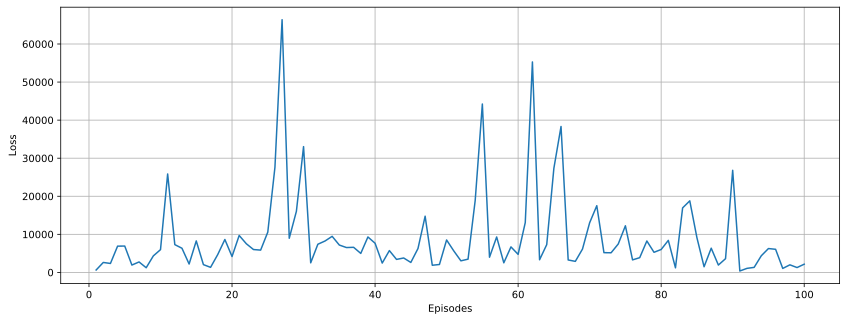

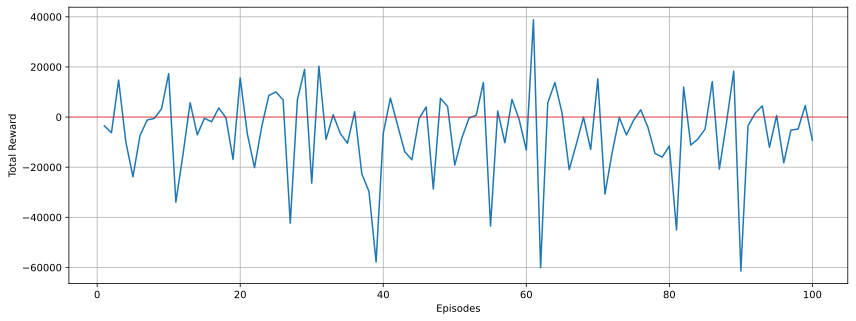

In [62]:
episodes = list(range(1, num_episodes + 1))

plt.figure(figsize=(14, 5))
plt.plot(episodes, episode_loss, linestyle='-')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.grid(True)
#plt.xticks(range(0, num_episodes + 1, 10))
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(episodes, episode_reward, linestyle='-')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.grid(True)
#plt.xticks(range(0, num_episodes + 1, 10))
plt.axhline(0, color='red', alpha=0.4)
plt.show()

We can observe that the loss and total reward barely converge after 100 episodes, which is quite reasonable since there are so many uncertainties in the stock market, and it usually requires thousands of episodes for the model to start showing signs of stability and convergence.

In [67]:
# test
lstm.eval()
env_test = StockTradingEnv(df_test_scaled, window=window_size)
state = env_test.reset()
total_reward = 0
done = False

while not done:
    action = agent.act(state, test=True) # only take the optimal action for test
    next_state, reward, done, info = env_test.step(action)
    total_reward += reward
    state = next_state

print(f"Test reward: {total_reward:.4f}, Total profit: {info['Total profit']}")

Test reward: 0.0000, Total profit: 0


In [66]:
#window_size = 100
env_test = StockTradingEnv(df_test_scaled, window=window_size)

state_size = df_test_scaled.shape[1]+3
action_size = env_test.action_space.n
lstm_test = DQN_lstm(input_dim=state_size, hidden_dim=64, output_dim=action_size).to(device)
lstm_test.load_state_dict(torch.load('lstm_model-100_episodes.pth'))
lstm_test.eval()

agent_test = Agent(state_size=state_size, action_size=action_size, dqn_model=lstm_test)
memory_test = ReplayMemory(capacity=10000)
trainer_test = Trainer(agent_test, memory_test)

state_test = env_test.reset()
total_reward_test = 0
done_test = False

while not done_test:
    action = agent_test.act(state_test, test=True) # only take the optimal action for test
    next_state, reward, done, info = env_test.step(action)
    total_reward_test += reward
    state_test = next_state

print(f"Test reward: {total_reward_test:.4f}, Total profit: {info['Total profit']}")

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 99 and the array at index 1 has size 100